In [234]:
import pandas as pd
import feather
import re
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
from sklearn import linear_model, datasets, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn import cross_validation as cv

pd.set_option('display.max_columns', None)
%matplotlib inline

In [314]:
df = feather.read_dataframe('NBA_DATA_1.feather')
df = df.groupby('playername').mean()

**Model 1 Linear Regression ALL FEATURES**

In [315]:
lm1 = smf.ols('WinPerc ~ FG + FGA  + FGPERC + THREEPT + THREEPTA + THREEPTPERC + eFGPERC + FT + FTA + FTPERC + PTS + ORB + ORBPERC + DRB + DRBPERC + TRB + TRBPERC + AST + STL + BLK + TOV + PF', data=df)
fit1 = lm1.fit()
print('R Squared: ', fit1.rsquared, '\nAdjusted R Squared: ', fit1.rsquared_adj)

R Squared:  0.48102359726 
Adjusted R Squared:  0.452267648823


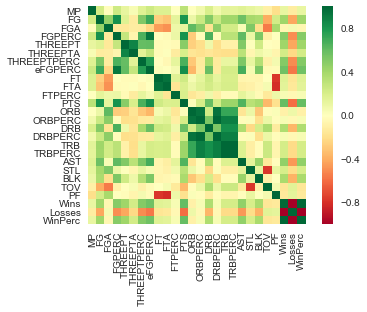

In [316]:
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

** ^^ FEATURES ARE TOO CORRELATED --- UPDATED LINEAR REGRESSION BELOW** 
**BETTER SOLUTION**
**Model ATTEMPT #2 **

In [318]:
fit2 = LinearRegression()

lm2 = smf.ols('WinPerc ~ FGA  + FGPERC + THREEPT + THREEPTPERC + eFGPERC + FTA + FTPERC + PTS + ORB + ORBPERC + DRB + AST + BLK + TOV + PF', data=df)
fit2 = lm2.fit()
print('R Squared: ', fit2.rsquared, '\nAdjusted R Squared: ', fit2.rsquared_adj)


R Squared:  0.43865146577 
Adjusted R Squared:  0.416780743657


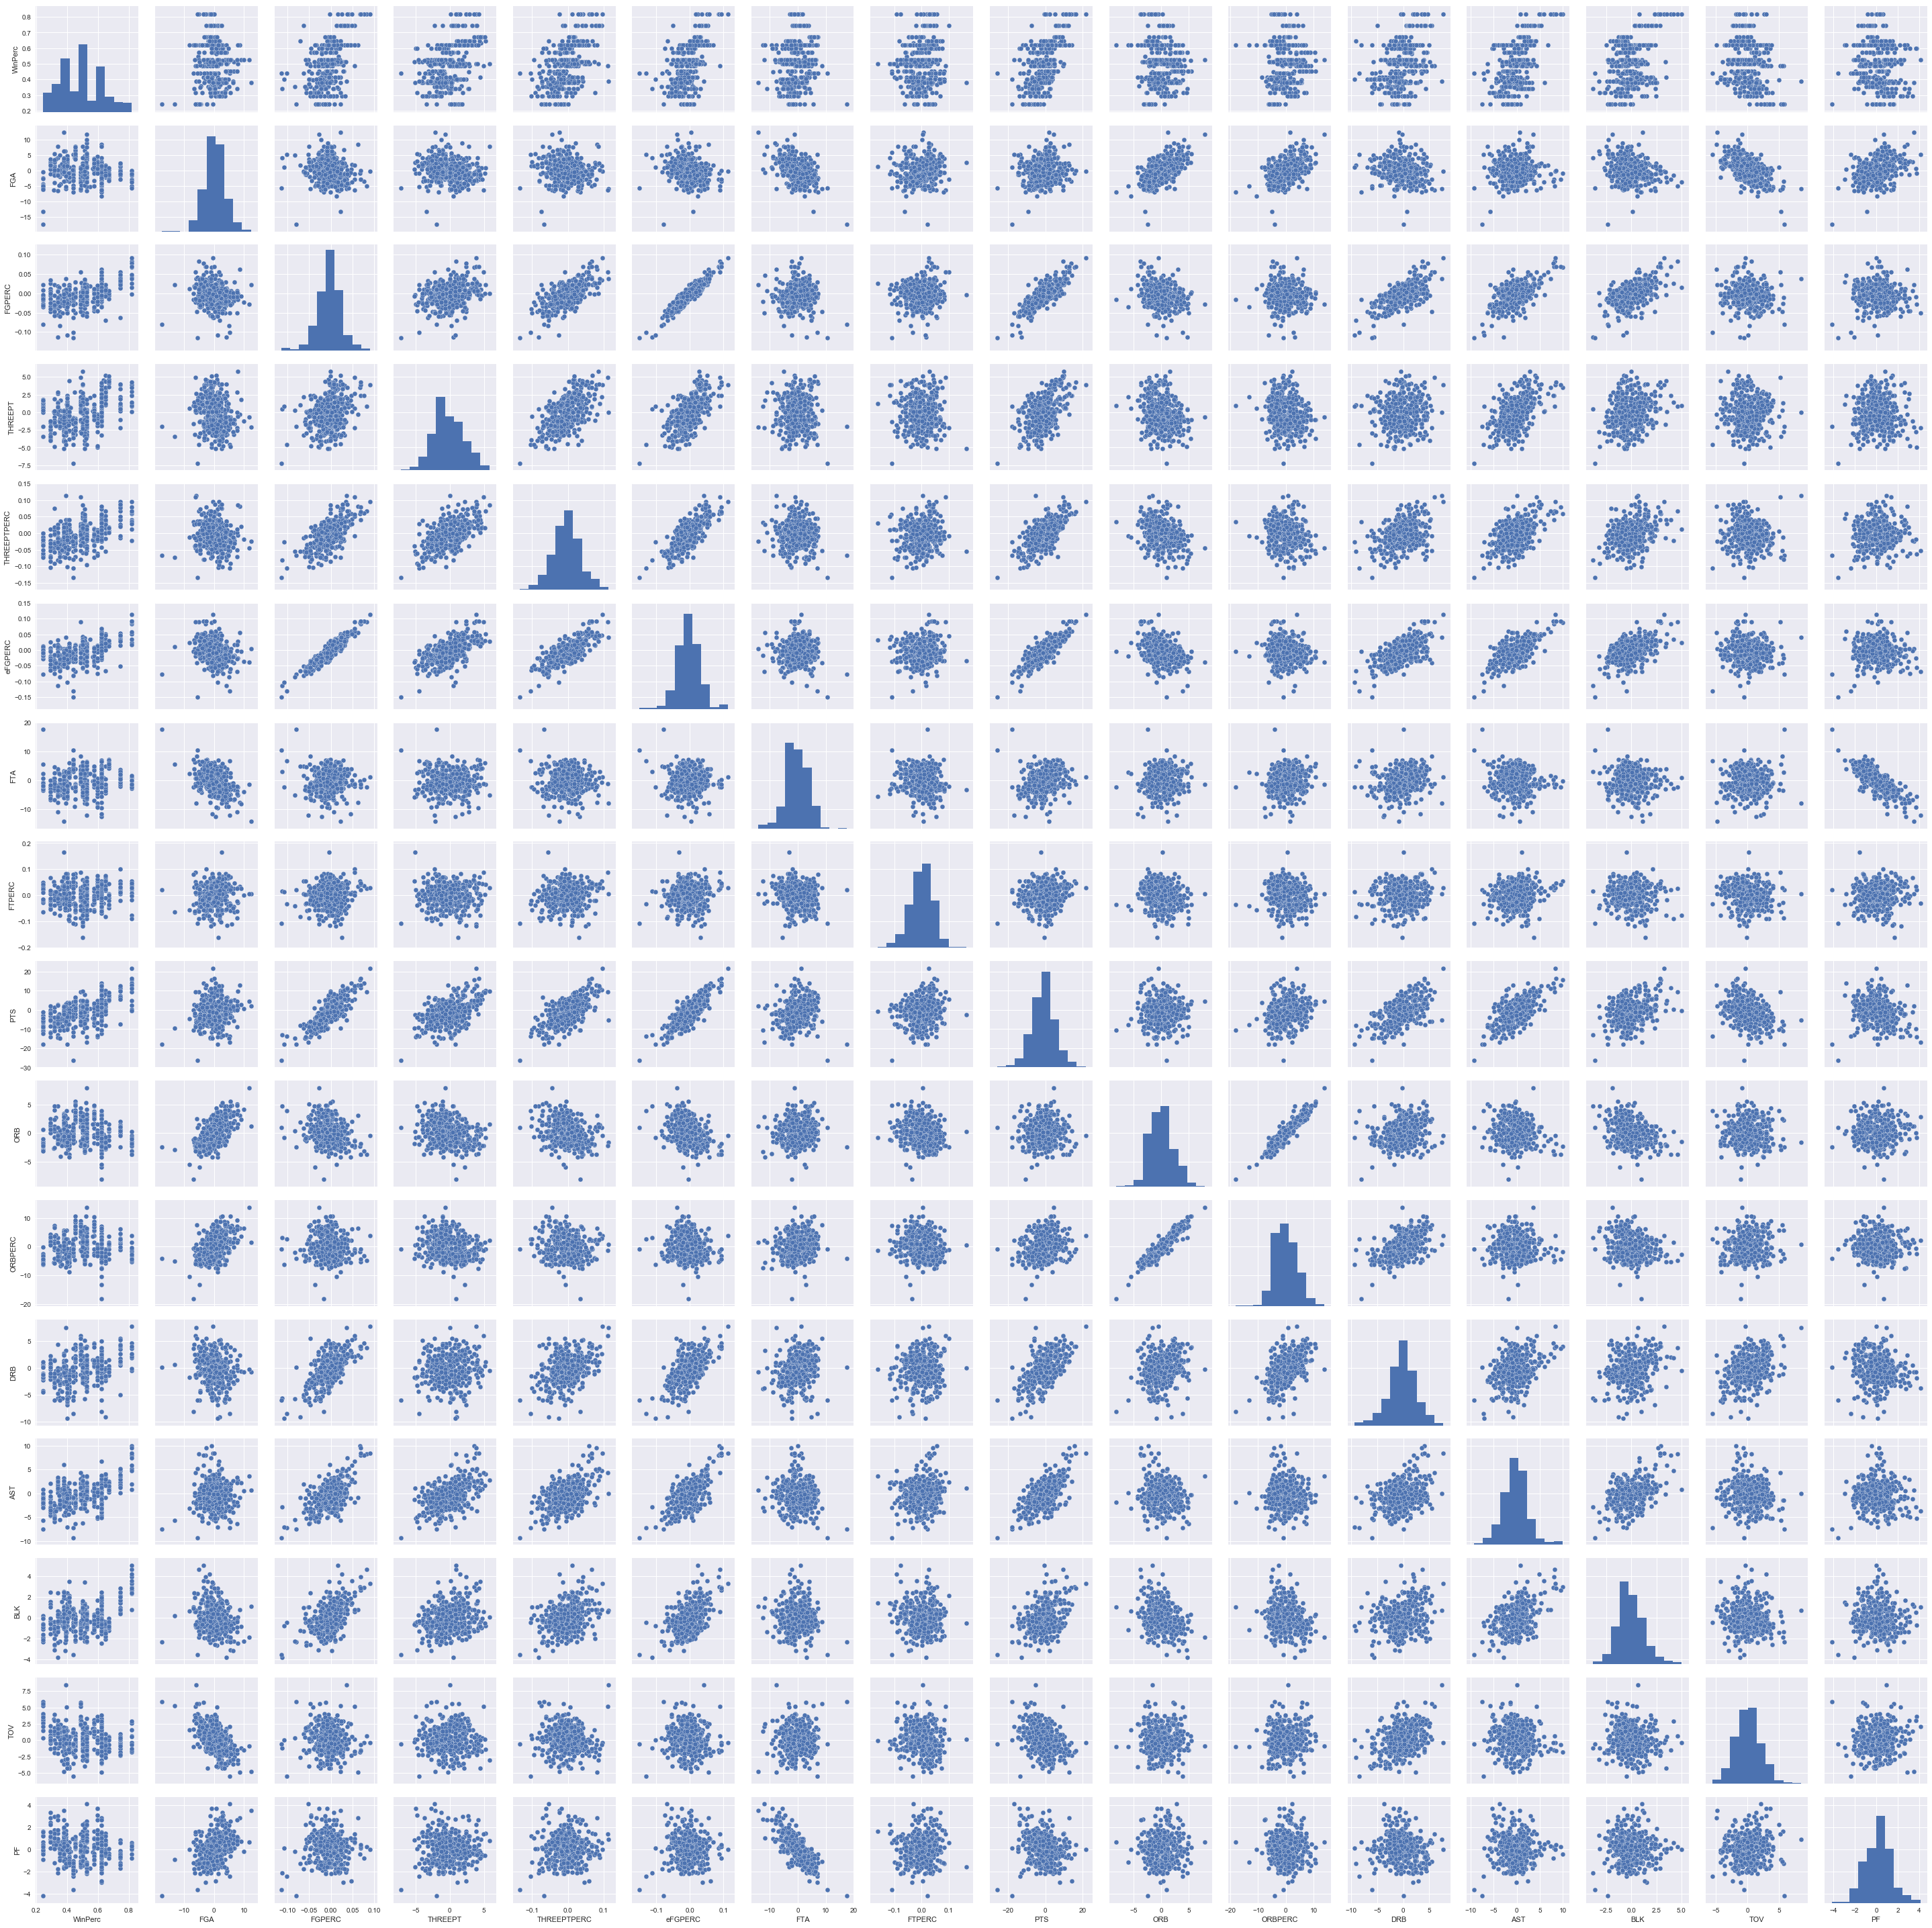

In [319]:
sns.pairplot(df[['WinPerc',  'FGA', 'FGPERC', 'THREEPT',  'THREEPTPERC', 'eFGPERC', 'FTA', 'FTPERC', 'PTS', 'ORB', 'ORBPERC', 'DRB', 'AST', 'BLK', 'TOV','PF']])

In [320]:
## Based on the graphs, logging y might be a good value
fit3 = LinearRegression()
df['log_WinPerc']=np.log(df.WinPerc)

lm3 = smf.ols('log_WinPerc ~ FGA  + FGPERC + THREEPT + THREEPTPERC + eFGPERC + FTA + FTPERC + PTS + ORB + ORBPERC + DRB + AST + BLK + TOV + PF', data=df)
fit3 = lm3.fit()
print('R Squared: ', fit3.rsquared, '\nAdjusted R Squared: ', fit3.rsquared_adj)

R Squared:  0.415445712773 
Adjusted R Squared:  0.392670870413


**TRAINING-TEST SET**

In [321]:
## Test ALL features
regall = LinearRegression()
XAll = df.iloc[:, 1:23]
y = df['log_WinPerc']

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(XAll, y, test_size=0.3)
regall.fit(X_train_all, y_train_all)
print('Test:', regall.score(X_test_all, y_test_all))
y_pred_all = regall.predict(X_test_all)
print ('MSE', np.sqrt(metrics.mean_squared_error(y_test_all, y_pred)))

Test: 0.438368201965
MSE 0.333493958541


In [322]:
## test SOME Features

reg = LinearRegression()

X = df[['FGA', 'FGPERC', 'THREEPT',  'THREEPTPERC',
'eFGPERC', 'FTA', 'FTPERC', 'PTS', 'ORB', 'ORBPERC', 'DRB', 'AST',
'BLK', 'TOV','PF']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
reg.fit(X_train, y_train)
print('Test:', reg.score(X_test, y_test))
y_pred = reg.predict(X_test)
print ('MSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test: 0.345532314248
MSE: 0.221367215938


** Can I Reduce this error with a lasso regression?**

In [323]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(n_alphas=50)
lasso.fit(X_train_all, y_train_all)
y_pred = lasso.predict(X_test_all)
print(np.sqrt(metrics.mean_squared_error(y_test_all, y_pred_all)))
print(lasso.alpha_, lasso.coef_)

0.218452456944
0.125432525758 [ 0.         -0.          0.          0.          0.          0.          0.
  0.          0.         -0.          0.02211221 -0.         -0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
 -0.        ]


(0, 1)

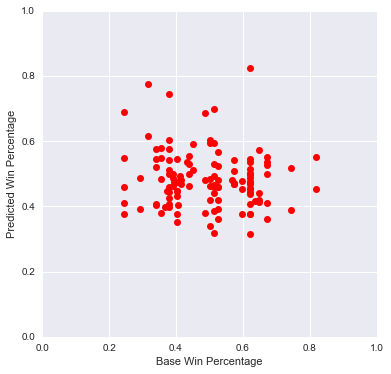

In [324]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(np.exp(y_test), np.exp(y_pred_all),'ro');
ax.set_xlabel('Base Win Percentage')
ax.set_ylabel('Predicted Win Percentage')

ax.set_xlim(0,1)
ax.set_ylim(0,1)

In [325]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(n_alphas=50)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(lasso.alpha_, lasso.coef_)

0.224856311628
0.00181269441246 [ 0.01245932  0.          0.03892568  0.          0.          0.01301993
 -0.         -0.00319804 -0.0140668   0.          0.04287868  0.01294659
  0.02632145 -0.04004868  0.        ]


(0, 1)

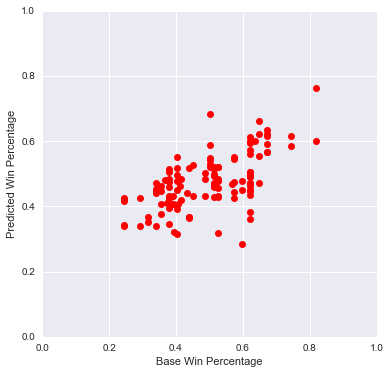

In [326]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(np.exp(y_test), np.exp(y_pred),'ro');
ax.set_xlabel('Base Win Percentage')
ax.set_ylabel('Predicted Win Percentage')

ax.set_xlim(0,1)
ax.set_ylim(0,1)

** How About Ridge Regression? **

In [327]:
##ALL FEATURES HIGHER IS BETTER IN SCORE
from sklearn.linear_model import RidgeCV
rcv = RidgeCV(cv=5)
rcv.fit(X_train_all, y_train_all)
print(rcv.score(X_train_all, y_train_all))
rcv.score(X_test_all, y_test_all)

0.411554717342


0.41646772132823129

In [328]:
## SOME Features HIGHER IS BETTER IN SCORE (Best Model So far)
rcv = RidgeCV(cv=5)
rcv.fit(X_train, y_train)
print(rcv.score(X_train, y_train))
rcv.score(X_test, y_test)

df['prediction'] = np.exp(rcv.predict(X))

0.408364586462


In [329]:

# df = df.reset_index()
# path = 'predictiondf.feather'
# feather.write_dataframe(df, path)

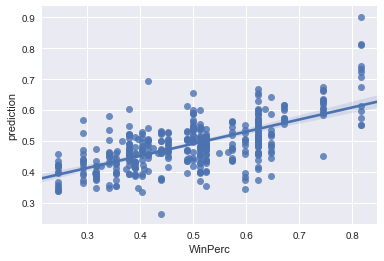

In [300]:
import seaborn as sns
sns.regplot(x="WinPerc", y="prediction", data=df, label='big')

**How About ElasticNet**

In [296]:
### All Features
from sklearn.linear_model import ElasticNetCV
EN = ElasticNetCV(cv=5)
EN.fit(X_train_all, y_train_all)
print(EN.score(X_train_all, y_train_all))
EN.score(X_test_all, y_test_all)


0.357898675032


NameError: name 'EM' is not defined

In [273]:
## Some Features
EN = ElasticNetCV(cv=5)
EN.fit(X_train, y_train)
print(EN.score(X_train, y_train))
EN.score(X_test, y_test)

0.309815739482


0.33562672749441558

In [295]:
y_pred2 = rcv.predict(X_test)
print(np.exp(y_pred2.min()), np.exp(y_pred2.max()))



0.372025919213 0.811380591619


**Polynomial Features**

In [291]:
from sklearn.preprocessing import PolynomialFeatures

degree = 1
pf = PolynomialFeatures(degree=degree)
X_train_pf = pf.fit_transform(X_train)
X_test_pf = pf.transform(X_test)

lr = LinearRegression()
lr = lr.fit(X_train_pf, y_train)

y_pred = lr.predict(X_test_pf)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.21936194649


In [290]:
#Polynomial on ElasticNet
EN = ElasticNetCV(cv=5)
EN.fit(X_train_pf, y_train_pf)
print(EN.score(X_train_pf, y_train))
EN.score(X_test_pf, y_test)

NameError: name 'y_train_pf' is not defined

In [195]:
# import warnings
# from sklearn.pipeline import make_pipeline

# warnings.filterwarnings("ignore")

# from sklearn.metrics import mean_squared_error

# # Step through degrees from 0 to 9 and store the training and test (generalization) error.
# # create array of zeros,
# train_error = np.empty(10)
# test_error = np.empty(10)
# for degree in range(10):
#     est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
#     est.fit(X_train, y_train)
#     train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
#     test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# # Plot the training and test errors against degree
# plt.figure(figsize=(8,6))
# plt.plot(np.arange(10), train_error, color='green', label='train')
# plt.plot(np.arange(10), test_error, color='red', label='test')
# plt.ylim((0.0, 1e0))
# plt.ylabel('log(mean squared error)')
# plt.xlabel('degree')
# plt.legend(loc='upper left')